# Load libraries and set device up

In [1]:
import seaborn           as sns
import numpy             as np
import matplotlib.pyplot as plt
import torch
import json
import os

import libraries.model   as clm
import libraries.dataset as cld

# Checking if pytorch can run in GPU, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

sns.set_theme()

# Define parameters

In [2]:
target = 'bandgap'
folder = 'bandgap-MChX'

r_folder = f'models/{folder}'
t_folder = f'targets/{folder}'

# Generate or load graph database for training

Reference dataset

In [3]:
files_names = {
    'r_dataset_std_name':      f'{r_folder}/train_dataset_std.pt',
    'r_std_parameters_name':   f'{r_folder}/standardized_parameters.json',
    'r_uncertainty_data_name': f'{r_folder}/uncertainty_data.json',
    'model_name':              f'{r_folder}/model.pt',
    'dt_param_name':           f'{r_folder}/dataset_parameters.json',
    't_dataset_name':          f'{t_folder}/dataset.pt'
}
cld.save_json(files_names, f'{t_folder}/files_names.json')

In [4]:
# Load the standardized dataset, with corresponding labels and parameters
r_dataset_std = torch.load(files_names['r_dataset_std_name'], weights_only=False)

# Load uncertainty data
r_uncertainty_data = cld.load_json(files_names['r_uncertainty_data_name'])

# Load std parameters data
r_std_parameters = cld.load_json(files_names['r_std_parameters_name'])

# Load dataset parameters data
r_dataset_parameters = cld.load_json(files_names['dt_param_name'])

# Defining target factor
target_factor = r_std_parameters['target_std'] / r_std_parameters['scale']

Prediciton dataset

In [5]:
if not os.path.exists(files_names['t_dataset_name']):
    # Generate data
    cld.generate_dataset(t_folder,
                         targets=['bandgap'],
                         data_folder=t_folder)

# Load the standardized dataset, with corresponding labels and parameters
t_dataset = torch.load(files_names['t_dataset_name'], weights_only=False)

# Determine the index for the desired property
target_idx = [idx for idx, t in enumerate(r_dataset_parameters['target']) if t == target][0]

# Select the target we want
for data in t_dataset:
    data.y = torch.tensor([data.y[target_idx]], dtype=torch.float)

# Select the target we want
ground_truths = np.array([data.y.item() for data in t_dataset])

# Standardize the dataset with
t_dataset_std = cld.standardize_dataset_from_keys(t_dataset, r_std_parameters)
del t_dataset

# Load model and make predictions

In [6]:
model = clm.load_model(r_dataset_std[0].num_node_features, 0, device, model_name=files_names['model_name'], purpose='eval')
model

DataParallel(
  (module): GCNN(
    (conv1): GraphConv(4, 32)
    (conv2): GraphConv(32, 32)
    (lin1): Linear(in_features=32, out_features=32, bias=True)
    (lin2): Linear(in_features=32, out_features=16, bias=True)
    (lin): Linear(in_features=16, out_features=1, bias=True)
  )
)

In [7]:
# Compute predictions
predictions, uncertainties, are_interpolated = clm.make_predictions(r_dataset_std,
                                                                    t_dataset_std,
                                                                    model, r_std_parameters, r_uncertainty_data)

# Plot predictions

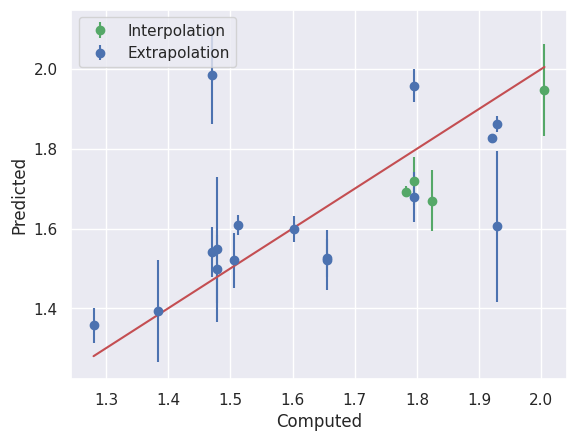

In [8]:
xpred = ground_truths[are_interpolated]
ypred = predictions[are_interpolated]
yerr  = uncertainties[are_interpolated]
plt.errorbar(xpred, ypred, yerr=np.abs(yerr),
             fmt='og', label='Interpolation')

xpred = ground_truths[~are_interpolated]
ypred = predictions[~are_interpolated]
yerr  = uncertainties[~are_interpolated]
plt.errorbar(xpred, ypred, yerr=np.abs(yerr),
             fmt='ob', label='Extrapolation')

_min_, _max_ = cld.get_min_max(ground_truths, predictions)
plt.plot([_min_, _max_], [_min_, _max_], '-r')
plt.xlabel('Computed')
plt.ylabel('Predicted')
plt.legend(loc='best')
plt.savefig(f'{t_folder}/UQ-prediction-comparison.pdf', dpi=50, bbox_inches='tight')
plt.show()

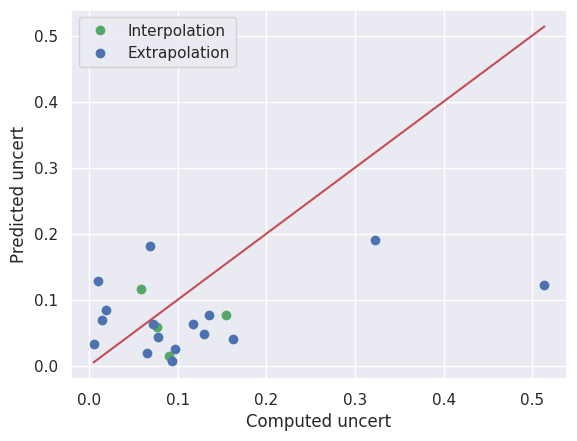

In [9]:
gt_uncertainties   = np.abs(ground_truths - predictions)
pred_uncertainties = np.abs(uncertainties)

xpred = gt_uncertainties[are_interpolated]
ypred = pred_uncertainties[are_interpolated]
plt.plot(xpred, ypred, 'og', label='Interpolation')

xpred = gt_uncertainties[~are_interpolated]
ypred = pred_uncertainties[~are_interpolated]
plt.plot(xpred, ypred, 'ob', label='Extrapolation')

_min_, _max_ = cld.get_min_max([gt_uncertainties, pred_uncertainties])
plt.plot([_min_, _max_], [_min_, _max_], '-r')
plt.xlabel(r'Computed uncert')
plt.ylabel(r'Predicted uncert')
plt.legend(loc='best')
plt.savefig(f'{t_folder}/UQ-values-comparison.pdf', dpi=50, bbox_inches='tight')
plt.show()